<div style="text-align: center;">
    <h2 style="font-weight: bold;background-color:#A1B341;border-bottom: 1px solid #0E46A3;border-radius: 12px 50px;font-family:cursive ;font-size: 30px;padding: 10px; margin-bottom: 10px; color:white;"><i> Fruits Prediction </i></h2>
</div>

<div style="text-align: center;">
    <!-- <h2 style="font-weight: bold; margin-bottom: 10px; color:#000080;"><i> </i></h2> -->
    <img src="https://www.allaboutlean.com/wp-content/uploads/2020/06/Selected-Fruits.jpg" alt="Image Title" style="max-width: 30%; height: auto;">
</div>

<a id="toc"></a>
### **Table of Contents**:
* Import Libraries
* Download Fruits-360 Data
* Preview the Images
* Model Trials
* Model Evaluation
* Prediction

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Import Libraries </i></h2>
</div>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dropout, BatchNormalization #Regularization
from keras.layers import Dense, Flatten, Conv2D,MaxPool2D, MaxPooling2D,Activation
from keras.layers import Input, RandomFlip, Rescaling, RandomRotation, Lambda # New Layers
from keras.preprocessing import image as keras_image
from keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import SGD
from PIL import Image
import keras.utils as image
import os
import pandas as pd

# not to display warnings
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Download Fruits-360 Data </i></h2>
</div>

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:16<00:00, 127MB/s] 
100% 1.28G/1.28G [00:16<00:00, 81.2MB/s]


In [ ]:
!unzip fruits.zip

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Preview the Images</i></h2>
</div> 

In [ ]:
train_path = 'fruits-360_dataset/fruits-360/Training/'
test_path = 'fruits-360_dataset/fruits-360/Test/'

In [ ]:
# Countin total labels
def count_labels(path):
    label_count = 0
    for _, dirs, _ in os.walk(path):
        label_count += len(dirs)
        break # only counts the top and exit the loop
    return label_count

num_label = count_labels(train_path)
print(f'Number of classes: {num_label}')

Number of classes: 131


In [ ]:
# Extracting labels from the directories
labels = [label for label in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, label))]

# Sort the labels alphabetically
sorted_labels = sorted(labels)



In [ ]:
train_name = []
train_img_name = []

for i in os.listdir(train_path):
    for train_img_fname in os.listdir(train_path+i):
        train_name.append(i)
        train_img_name.append(train_img_fname)

In [ ]:
df_train = pd.DataFrame(train_name, columns=['fruits_name'])
df_train['fruist_img'] = train_img_name

In [ ]:
df_train_nuniques = df_train['fruits_name'].value_counts().reset_index()
df_train_nuniques.head()

,fruits_name,count
0,Grape Blue,984
1,Plum 3,900
2,Cherry Rainier,738
3,Strawberry Wedge,738
4,Peach 2,738


In [ ]:
df_sorted = df_train_nuniques.sort_values(by='count', ascending=False)

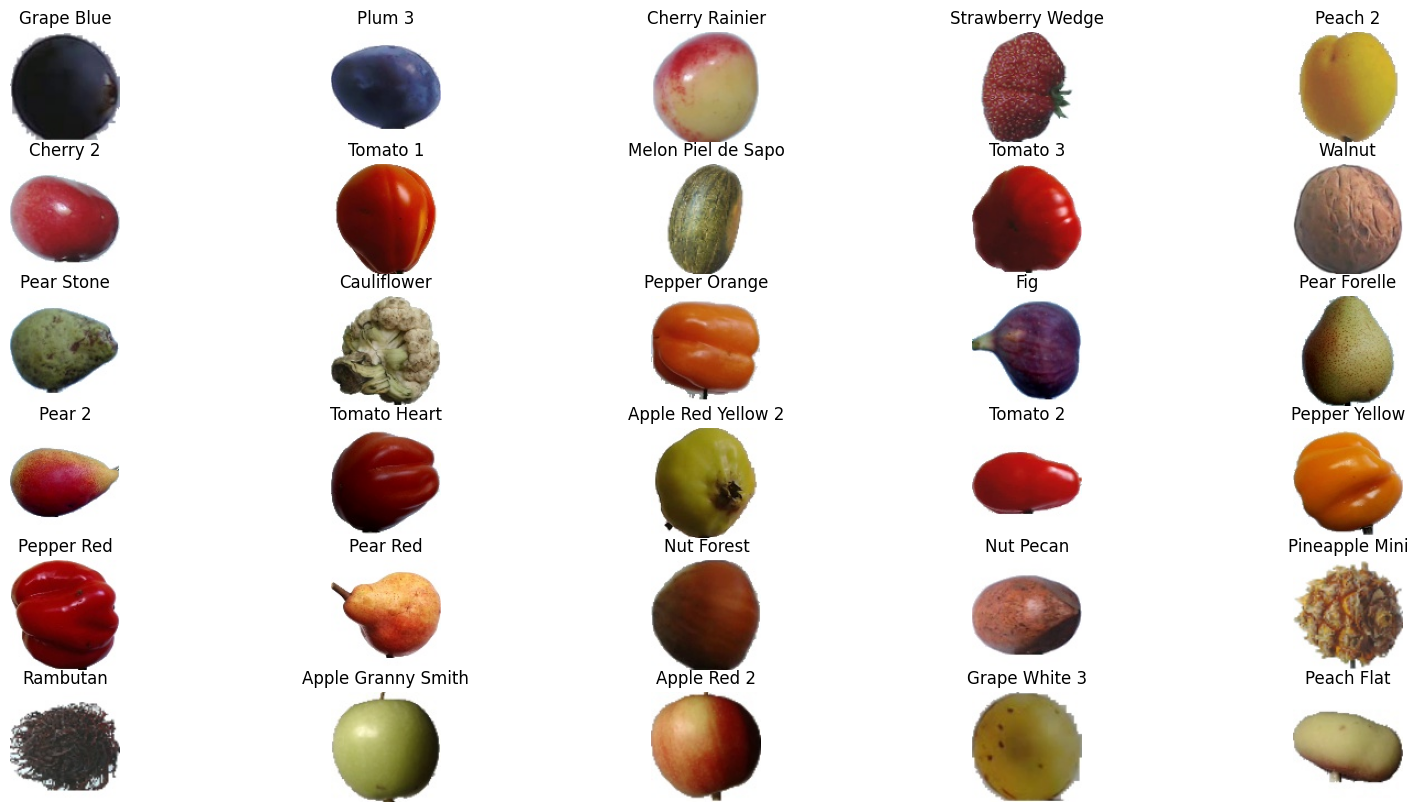

In [ ]:
fig = plt.figure(figsize=(20,10))

for i in range(30):
    ax = fig.add_subplot(6,5,i+1, xticks=[], yticks=[])
    plt.title(df_train_nuniques['fruits_name'][i])
    plt.axis('off')
    file = os.listdir(train_path + df_train_nuniques['fruits_name'][i])

    img_name = file[0]
    ax.imshow(image.load_img(train_path + df_train_nuniques['fruits_name'][i] + '/' + img_name))

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Trial No. 1 </i></h2>
</div>  

## Set Global Parameters

In [ ]:
SEED = 1234
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
keras.utils.set_random_seed(SEED)

## Load & Preprocess the Data

In [ ]:
train_data = ImageDataGenerator(rescale=1./255,
                                shear_range=.2,
                                zoom_range=.2,
                                horizontal_flip=True,
                                validation_split=.2)

test_data = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data.flow_from_directory('/content/fruits-360_dataset/fruits-360/Training',
                                                 target_size=(100, 100),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 subset="training")

validation_generator = train_data.flow_from_directory("/content/fruits-360_dataset/fruits-360/Training",
                                                      target_size=(100, 100),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      subset='validation')

test_generator = train_data.flow_from_directory('/content/fruits-360_dataset/fruits-360/Test',
                                                target_size=(100, 100),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
image_files = os.listdir('/content/fruits-360_dataset/fruits-360/Test')
image_files = [file for file in image_files if file.endswith(('jpg', 'jpeg', 'png'))]

##i) CNN Baseline Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(131, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       36992     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                   

## ii) Model Compilation & Training

In [ ]:
model.compile(optimizer ='adam', loss ='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
hist = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=validation_generator)

Epoch 1/50
1694/1694 [==============================] - 242s 138ms/step - loss: 2.7916 - accuracy: 0.2830 - val_loss: 1.0471 - val_accuracy: 0.7263
Epoch 2/50
1694/1694 [==============================] - 225s 133ms/step - loss: 1.1636 - accuracy: 0.6254 - val_loss: 0.7197 - val_accuracy: 0.8319
Epoch 3/50
1694/1694 [==============================] - 229s 135ms/step - loss: 0.8357 - accuracy: 0.7256 - val_loss: 0.5875 - val_accuracy: 0.8492
Epoch 4/50
1694/1694 [==============================] - 226s 133ms/step - loss: 0.6664 - accuracy: 0.7803 - val_loss: 0.4701 - val_accuracy: 0.8690
Epoch 5/50
1694/1694 [==============================] - 227s 134ms/step - loss: 0.5390 - accuracy: 0.8215 - val_loss: 0.3293 - val_accuracy: 0.9155
Epoch 6/50
1694/1694 [==============================] - 225s 133ms/step - loss: 0.4354 - accuracy: 0.8564 - val_loss: 0.3440 - val_accuracy: 0.9099
Epoch 7/50
1694/1694 [==============================] - 222s 131ms/step - loss: 0.3704 - accuracy: 0.8762 - val_

## iii) Model Evaluation

In [ ]:
accuracy = hist.history['accuracy']
loss = hist.history['loss']

Text(0.5, 1.0, 'Model Accuracy')

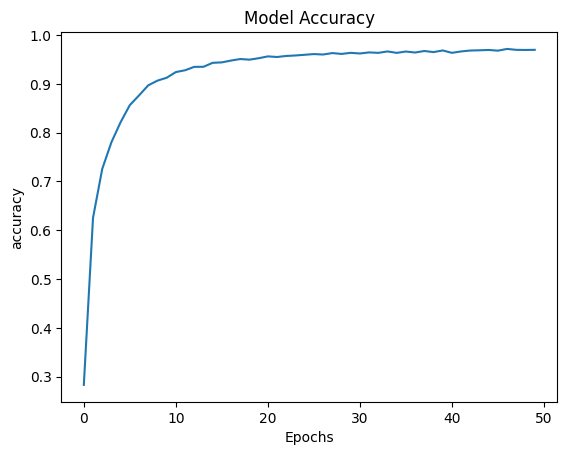

In [ ]:
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Loss')

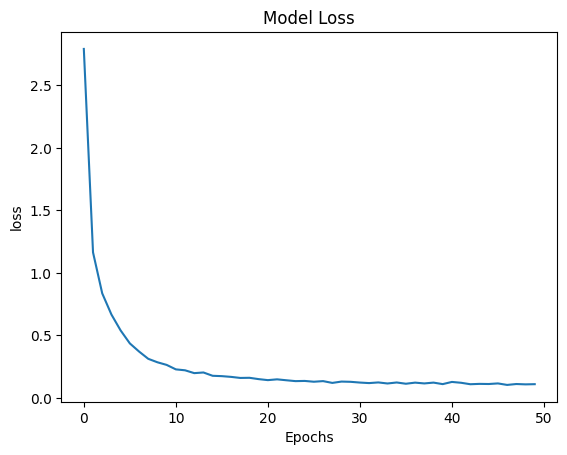

In [ ]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Model Loss')

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Trial No.2 </i></h2>
</div> 

## i) RESNET Model With Augmentaion

In [ ]:
def augmentor(images, layers):
  for layer in layers:
    imgs = layer(images)
  return imgs

In [ ]:
resnet_model = Sequential()

pretrained_model = keras.applications.ResNet50(include_top=False,
                                               input_shape=(100, 100, 3),
                                               pooling='avg',
                                               classes=131,
                                               weights='imagenet')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
layers = [RandomFlip('horizontal'), RandomRotation(0.1)]

In [ ]:
model = Sequential()

model.add(Lambda(lambda x: (augmentor(x, layers)), input_shape=(100, 100, 3)))
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(131, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 100, 100, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 131)               67203     
                                                                 
Total params: 24704003 (94.24 MB)
Trainable params: 1116291 (4.26 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## ii) Model Compilation & Training

In [ ]:
model.compile(optimizer ='adam', loss ='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
hist = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=validation_generator)

Epoch 1/30
1694/1694 [==============================] - 254s 147ms/step - loss: 4.5016 - accuracy: 0.0383 - val_loss: 4.0560 - val_accuracy: 0.0723
Epoch 2/30
1694/1694 [==============================] - 245s 145ms/step - loss: 3.9847 - accuracy: 0.0735 - val_loss: 3.7831 - val_accuracy: 0.0851
Epoch 3/30
1694/1694 [==============================] - 252s 148ms/step - loss: 3.8284 - accuracy: 0.0856 - val_loss: 3.7299 - val_accuracy: 0.0959
Epoch 4/30
1694/1694 [==============================] - 281s 166ms/step - loss: 3.7415 - accuracy: 0.0942 - val_loss: 3.6950 - val_accuracy: 0.1023
Epoch 5/30
1694/1694 [==============================] - 249s 147ms/step - loss: 3.6647 - accuracy: 0.1070 - val_loss: 3.5906 - val_accuracy: 0.1173
Epoch 6/30
1694/1694 [==============================] - 249s 147ms/step - loss: 3.5943 - accuracy: 0.1164 - val_loss: 3.5376 - val_accuracy: 0.1275
Epoch 7/30
1694/1694 [==============================] - 248s 146ms/step - loss: 3.5350 - accuracy: 0.1258 - val_

## iii) Model Evaluation

In [ ]:
_, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy}")

709/709 [==============================] - 82s 116ms/step - loss: 3.0348 - accuracy: 0.2277
Test Accuracy: 0.2276533842086792


In [ ]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

Text(0.5, 1.0, 'Loss')

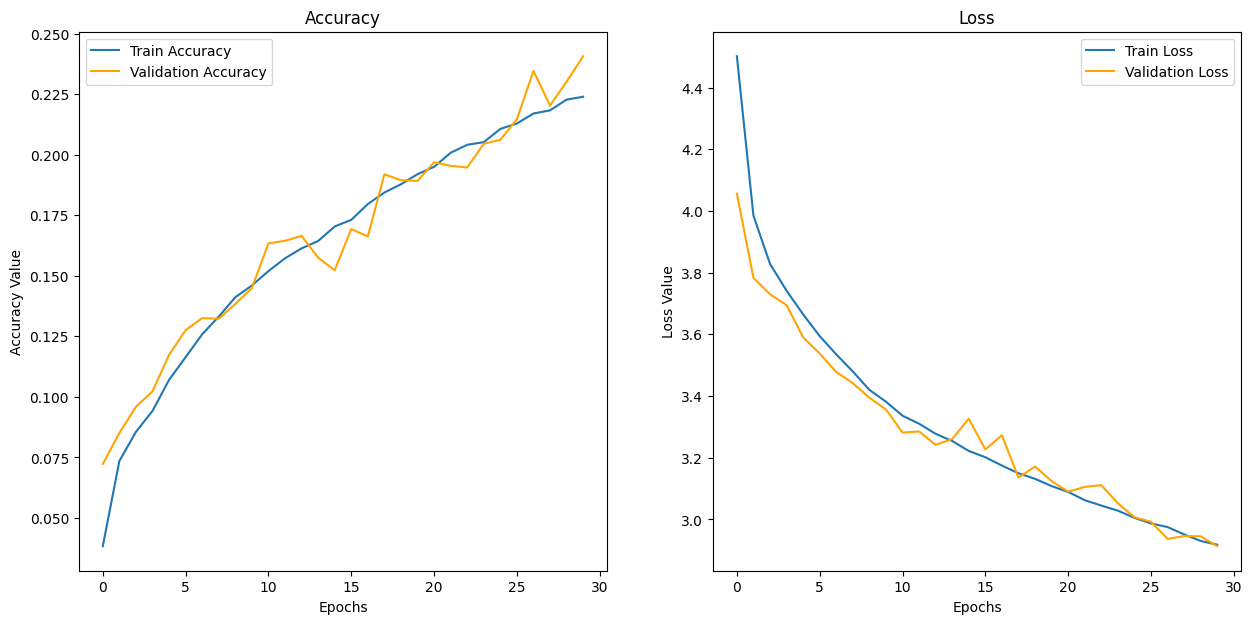

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.plot(train_accuracy)
plt.plot(val_accuracy, color='orange')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.title('Accuracy')

plt.subplot(122)
plt.plot(train_loss)
plt.plot(val_loss, color='orange')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Loss')

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Trial No.3 </i></h2>
</div> 

## Steting global parameters

In [ ]:
SEED = 907
BATCH_SIZE = 64
EPOCH = 15

## Preprocess the Dataset

In [ ]:
# Training Generator/Dataset
train_datagen = ImageDataGenerator(rescale = 1./255.0,
                                   validation_split=0.15
                                  )

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (100, 100),
                                                 batch_size = BATCH_SIZE,
                                                 seed=SEED,
                                                 subset='training',
                                                 class_mode = 'categorical')

Found 57612 images belonging to 131 classes.


In [ ]:
# Valedation Generator/Dataset
val_img_generator = ImageDataGenerator(
                   rescale=1/255.,
                   validation_split=0.15
                   )

val_set = val_img_generator.flow_from_directory(train_path,
                                                 target_size = (100, 100),
                                                 seed=SEED,
                                                 subset='validation',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 10080 images belonging to 131 classes.


In [ ]:
# Testing Generator/Dataset
test_img_generator = ImageDataGenerator(
                   rescale=1/255.,
                   )

test_set = test_img_generator.flow_from_directory(test_path,
                                                 target_size = (100, 100),
                                                 seed=SEED,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 22688 images belonging to 131 classes.


## i) Effecientnent b0 Model Without Augmentation

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(100, 100, 3))
    model = InceptionV3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    x = Flatten()(model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(131, activation='softmax')(x)



    # Compile
    model = keras.Model(inputs, output, name="inception")
    print( model.summary())
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
NUM_CLASSES = 131
model = build_model(num_classes=NUM_CLASSES)

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 49, 49, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 49, 49, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 49, 49, 32)           0         ['batch_normalization_

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=1)

## ii) Model training

In [ ]:
steps_per_epoch = train_set.samples // BATCH_SIZE

validation_steps = val_set.samples // BATCH_SIZE

callback_2 = model.fit(
                    train_set, epochs=EPOCH,

                    validation_data=val_set,

                    steps_per_epoch=steps_per_epoch,

                    validation_steps=validation_steps,
                    callbacks= [early_stopping],
                    batch_size = BATCH_SIZE

                    )

Epoch 1/15
900/900 [==============================] - 906s 999ms/step - loss: 1.9053 - accuracy: 0.5718 - val_loss: 0.4665 - val_accuracy: 0.8889
Epoch 2/15
900/900 [==============================] - 917s 1s/step - loss: 0.4309 - accuracy: 0.8894 - val_loss: 0.2886 - val_accuracy: 0.9241
Epoch 3/15
900/900 [==============================] - 956s 1s/step - loss: 0.2047 - accuracy: 0.9483 - val_loss: 0.2465 - val_accuracy: 0.9309
Epoch 4/15
900/900 [==============================] - 898s 998ms/step - loss: 0.1218 - accuracy: 0.9712 - val_loss: 0.2356 - val_accuracy: 0.9362
Epoch 5/15
900/900 [==============================] - 909s 1s/step - loss: 0.0812 - accuracy: 0.9808 - val_loss: 0.2147 - val_accuracy: 0.9405
Epoch 6/15
900/900 [==============================] - 888s 987ms/step - loss: 0.0609 - accuracy: 0.9859 - val_loss: 0.2131 - val_accuracy: 0.9442
Epoch 7/15
900/900 [==============================] - 907s 1s/step - loss: 0.0463 - accuracy: 0.9892 - val_loss: 0.1934 - val_accurac

## iii) Model evaluation on test

In [ ]:
test_evaluation = model.evaluate(test_set)
print("Test Evaluation Loss: {:.2f}%".format(test_evaluation[0]*100))
print("Test Evaluation Accuracy: {:.2f}%".format(test_evaluation[1]*100))

355/355 [==============================] - 307s 865ms/step - loss: 0.3638 - accuracy: 0.9146
Test Evaluation Loss: 36.38%
Test Evaluation Accuracy: 91.46%


## iv) Result Visualization

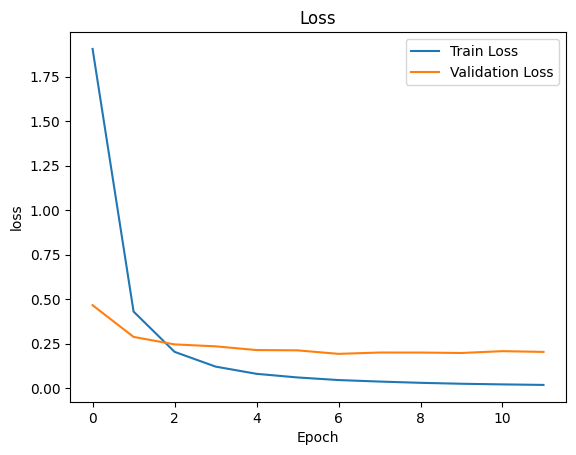

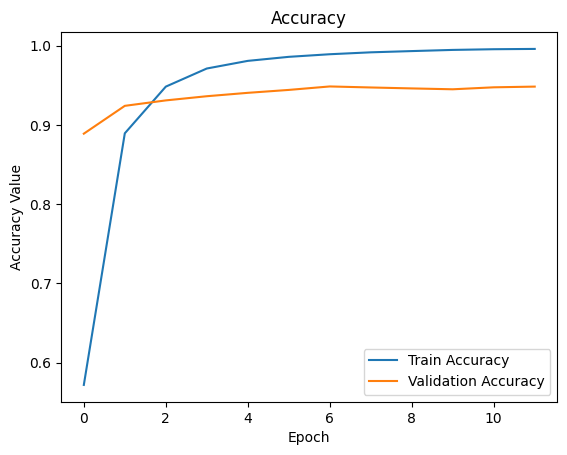

In [ ]:
plt.plot(callback_2.history['loss'], label='Train Loss')
plt.plot(callback_2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.plot(callback_2.history['accuracy'],label='Train Accuracy')
plt.plot(callback_2.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

## Predict

2/2 [==============================] - 2s 380ms/step


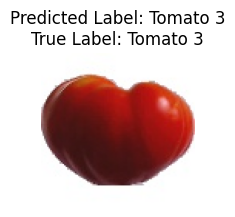

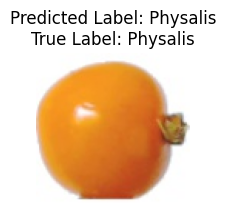

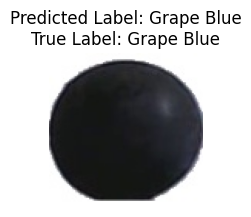

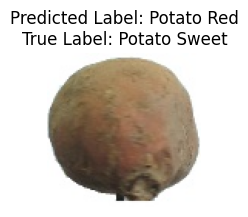

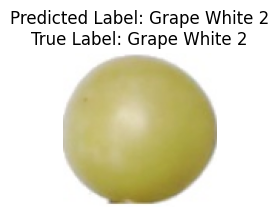

In [ ]:
test_images, test_labels = next(test_set)
predictions = model.predict(test_images)

for i in range(5):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f'Predicted Label: {predicted_label}\nTrue Label: {true_label}')
    plt.axis('off')
    plt.show()

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Trial No.4 </i></h2>
</div> 

## Set Global Parameters

In [ ]:
SEED = 907
BATCH_SIZE = 64
EPOCH = 20

## Load & Preprocess the Dataset

In [ ]:
train_img_gen = ImageDataGenerator(
                                  rescale=1./255.0,
                                  rotation_range=0.15,
                                  zoom_range=0.15,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip=True,
                                  validation_split=0.15
                                  )



test_img_gen = ImageDataGenerator(rescale=1./255.0)

In [ ]:
# Training Generator/Dataset
train_img_ds = train_img_gen.flow_from_directory(
    directory='fruits-360_dataset/fruits-360/Training',
    target_size=(100, 100),
    class_mode='categorical',
    subset='training',
    seed=SEED,
    batch_size=BATCH_SIZE
)

# Validation Generator/Dataset
val_img_ds = train_img_gen.flow_from_directory(
    directory='fruits-360_dataset/fruits-360/Training',
    target_size=(100, 100),
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    batch_size=BATCH_SIZE
)


# Testing Generator/Dataset
test_img_ds = test_img_gen.flow_from_directory(
    directory='fruits-360_dataset/fruits-360/Test',
    target_size=(100, 100),
    class_mode='categorical',
    subset=None,
    seed=SEED,
    batch_size=BATCH_SIZE
)




## i) CNN Model With Augmentation

In [ ]:
model=Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(100,100,3), activation="relu"))
model.add(Conv2D(32, (3,3), padding="same", activation="relu" ))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(Conv2D(64, (3,3), padding="same", activation="relu" ))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
model.add(Conv2D(128, (3,3), padding="same", activation="relu" ))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(131, activation="softmax"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        36928     
                                                      

## ii) Model Compilation & Training

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_img_ds.samples // BATCH_SIZE

validation_steps = val_img_ds.samples // BATCH_SIZE

callback = model.fit(train_img_ds, epochs=EPOCH,
                        validation_data=val_img_ds,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps
                        )

Epoch 1/20
900/900 [==============================] - 232s 256ms/step - loss: 1.9375 - accuracy: 0.4804 - val_loss: 0.5443 - val_accuracy: 0.8459
Epoch 2/20
900/900 [==============================] - 232s 258ms/step - loss: 0.4404 - accuracy: 0.8693 - val_loss: 0.3375 - val_accuracy: 0.9118
Epoch 3/20
900/900 [==============================] - 242s 268ms/step - loss: 0.2298 - accuracy: 0.9309 - val_loss: 0.2189 - val_accuracy: 0.9399
Epoch 4/20
900/900 [==============================] - 243s 270ms/step - loss: 0.1660 - accuracy: 0.9527 - val_loss: 0.1931 - val_accuracy: 0.9453
Epoch 5/20
900/900 [==============================] - 243s 270ms/step - loss: 0.1328 - accuracy: 0.9616 - val_loss: 0.3295 - val_accuracy: 0.9294
Epoch 6/20
900/900 [==============================] - 238s 264ms/step - loss: 0.1193 - accuracy: 0.9666 - val_loss: 0.2572 - val_accuracy: 0.9443
Epoch 7/20
900/900 [==============================] - 251s 279ms/step - loss: 0.1036 - accuracy: 0.9727 - val_loss: 0.2615 -

## iii) Model Evaluation

In [ ]:
train_evaluation = model.evaluate(train_img_ds)
print("Train Evaluation Loss: {:.2f}%".format(train_evaluation[0]*100))
print("Train Evaluation Accuracy: {:.2f}%".format(train_evaluation[1]*100))

901/901 [==============================] - 190s 211ms/step - loss: 0.0312 - accuracy: 0.9948
Train Evaluation Loss: 3.12%
Train Evaluation Accuracy: 99.48%


In [ ]:
val_evaluation = model.evaluate(val_img_ds)
print("Validation Evaluation Loss: {:.2f}%".format(val_evaluation[0]*100))
print("Validation Evaluation Accuracy: {:.2f}%".format(val_evaluation[1]*100))

158/158 [==============================] - 33s 212ms/step - loss: 0.3072 - accuracy: 0.9711
Validation Evaluation Loss: 30.72%
Validation Evaluation Accuracy: 97.11%


In [ ]:
test_evaluation = model.evaluate(test_img_ds)
print("Test Evaluation Loss: {:.2f}%".format(test_evaluation[0]*100))
print("Test Evaluation Accuracy: {:.2f}%".format(test_evaluation[1]*100))

355/355 [==============================] - 15s 43ms/step - loss: 0.2727 - accuracy: 0.9802
Test Evaluation Loss: 27.27%
Test Evaluation Accuracy: 98.02%


## iv) Result Visualization

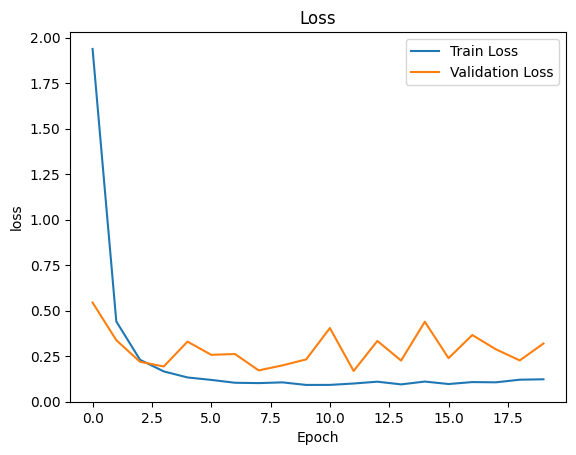

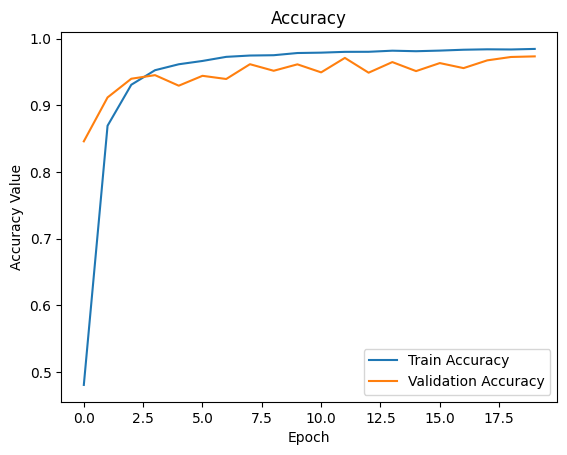

In [ ]:
plt.plot(callback.history['loss'], label='Train Loss')
plt.plot(callback.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.plot(callback.history['accuracy'],label='Train Accuracy')
plt.plot(callback.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Trial No.5 </i></h2>
</div> 

## `+` Set Global Parameters

In [ ]:
SEED=1234
BATCH=64
Input_shape=(100,100,3)
EPOCHS = 15

### Load & Preprocess the Dataset

In [ ]:
train_data_dir='/content/fruits-360_dataset/fruits-360/Training'
test_data_dir='/content/fruits-360_dataset/fruits-360/Test'

#### preprocessing

In [ ]:
train_img_gen = ImageDataGenerator(
     rescale=1./255,   #grey images
    shear_range=0.3,  #rotating images randomly
    horizontal_flip=True,  #randomly flip image 90 degree
    zoom_range=0.3

)

In [ ]:
test_img_gen = ImageDataGenerator(
    validation_split=0.15,
    rescale=1/255.
)

In [ ]:
train_generator   = train_img_gen.flow_from_directory(
                  directory= train_data_dir ,
                  target_size =(100, 100), # resize to this size
                  shuffle=True ,
                  subset = 'training',
                  color_mode="rgb", # for coloured images
                  batch_size=BATCH, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=SEED # to make the result reproducible
                  )

Found 67692 images belonging to 131 classes.


In [ ]:
Val_generator = test_img_gen.flow_from_directory(
                  directory= train_data_dir ,
                  target_size =(100, 100), # resize to this size
                  shuffle=True ,
                  subset = 'validation',
                  color_mode="rgb", # for coloured images
                  batch_size=BATCH, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=SEED # to make the result reproducible
                  )

Found 10080 images belonging to 131 classes.


In [ ]:
test_generator = test_img_gen.flow_from_directory(
                  directory= test_data_dir ,
                  target_size =(100, 100), # resize to this size
                  shuffle=True ,
                  # subset = 'validation',
                  color_mode="rgb", # for coloured images
                  batch_size=BATCH, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=SEED # to make the result reproducible
                  )

Found 22688 images belonging to 131 classes.


### Preview the Images

In [ ]:
num_classes = len(train_generator.class_indices)
print("Number of Classes:", num_classes)

Number of Classes: 131


In [ ]:
train_generator.class_indices.items()

dict_items([('Apple Braeburn', 0), ('Apple Crimson Snow', 1), ('Apple Golden 1', 2), ('Apple Golden 2', 3), ('Apple Golden 3', 4), ('Apple Granny Smith', 5), ('Apple Pink Lady', 6), ('Apple Red 1', 7), ('Apple Red 2', 8), ('Apple Red 3', 9), ('Apple Red Delicious', 10), ('Apple Red Yellow 1', 11), ('Apple Red Yellow 2', 12), ('Apricot', 13), ('Avocado', 14), ('Avocado ripe', 15), ('Banana', 16), ('Banana Lady Finger', 17), ('Banana Red', 18), ('Beetroot', 19), ('Blueberry', 20), ('Cactus fruit', 21), ('Cantaloupe 1', 22), ('Cantaloupe 2', 23), ('Carambula', 24), ('Cauliflower', 25), ('Cherry 1', 26), ('Cherry 2', 27), ('Cherry Rainier', 28), ('Cherry Wax Black', 29), ('Cherry Wax Red', 30), ('Cherry Wax Yellow', 31), ('Chestnut', 32), ('Clementine', 33), ('Cocos', 34), ('Corn', 35), ('Corn Husk', 36), ('Cucumber Ripe', 37), ('Cucumber Ripe 2', 38), ('Dates', 39), ('Eggplant', 40), ('Fig', 41), ('Ginger Root', 42), ('Granadilla', 43), ('Grape Blue', 44), ('Grape Pink', 45), ('Grape Whit

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3', 5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3', 10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado', 15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beetroot', 20: 'Blueberry', 21: 'Cactus fruit', 22: 'Cantaloupe 1', 23: 'Cantaloupe 2', 24: 'Carambula', 25: 'Cauliflower', 26: 'Cherry 1', 27: 'Cherry 2', 28: 'Cherry Rainier', 29: 'Cherry Wax Black', 30: 'Cherry Wax Red', 31: 'Cherry Wax Yellow', 32: 'Chestnut', 33: 'Clementine', 34: 'Cocos', 35: 'Corn', 36: 'Corn Husk', 37: 'Cucumber Ripe', 38: 'Cucumber Ripe 2', 39: 'Dates', 40: 'Eggplant', 41: 'Fig', 42: 'Ginger Root', 43: 'Granadilla', 44: 'Grape Blue', 45: 'Grape Pink', 46: 'Grape White', 47: 'Grape White 2', 48: 'Grape White 3', 49: 'Grape White 4', 50: 'Grapefruit Pink', 51: 'Grape

show images

In [ ]:
img_to_array(load_img(train_data_dir+"/Apple Braeburn/0_100.jpg")).shape

(100, 100, 3)

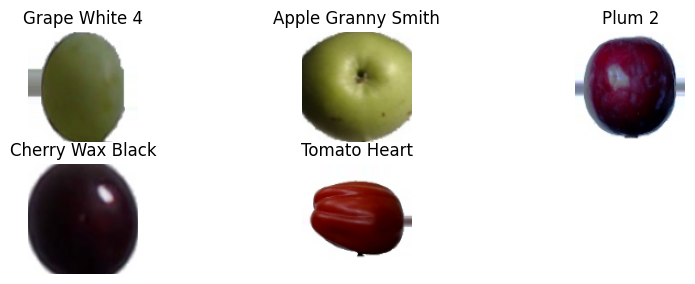

In [ ]:
plt.figure(figsize=(10, 10))
images_train , labels_train = train_generator.next()

for i in range(5):
    plt.subplot(6, 3, i+1)
    plt.imshow(images_train[i])
    plt.title(labels[np.argmax(labels_train[i])])
    plt.axis('off')


plt.show()

# `+` Model Design

In [ ]:
# Define early stopping callback
early_stop=EarlyStopping(monitor='accuracy',patience=8,restore_best_weights=True)

In [ ]:
# Step 3: VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=Input_shape)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Freeze all layers by default
base_model.trainable = False

# Unfreeze some layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:

# Step 4: Add Custom Fully Connected Layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(131, activation='softmax'))  # Assuming 131 classes

# Step 5: Training
model.compile(optimizer=keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH,
    epochs=EPOCHS,
    validation_data=Val_generator,
    validation_steps=Val_generator.samples // BATCH,
    callbacks=[early_stop]


)


Epoch 1/15
1057/1057 [==============================] - 260s 240ms/step - loss: 1.3971 - accuracy: 0.6423 - val_loss: 0.3440 - val_accuracy: 0.8811
Epoch 2/15
1057/1057 [==============================] - 250s 237ms/step - loss: 0.5296 - accuracy: 0.8387 - val_loss: 0.3121 - val_accuracy: 0.9038
Epoch 3/15
1057/1057 [==============================] - 249s 235ms/step - loss: 0.4626 - accuracy: 0.8641 - val_loss: 0.3051 - val_accuracy: 0.9058
Epoch 4/15
1057/1057 [==============================] - 245s 232ms/step - loss: 0.4634 - accuracy: 0.8738 - val_loss: 0.2533 - val_accuracy: 0.9240
Epoch 5/15
1057/1057 [==============================] - 248s 235ms/step - loss: 0.4634 - accuracy: 0.8801 - val_loss: 0.1560 - val_accuracy: 0.9547
Epoch 6/15
1057/1057 [==============================] - 247s 234ms/step - loss: 0.4576 - accuracy: 0.8853 - val_loss: 0.4571 - val_accuracy: 0.8774
Epoch 7/15
1057/1057 [==============================] - 248s 234ms/step - loss: 0.4079 - accuracy: 0.8998 - val_

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dense_1 (Dense)             (None, 131)               67203     
                                                                 
Total params: 17141699 (65.39 MB)
Trainable params: 2427011 (9.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Save the model to a file
joblib.dump(model, 'VGG16.pkl')

# Load the model from the file
# model = joblib.load('model_filename.pkl')

['VGG16.pkl']

In [ ]:
train_evaluation = model.evaluate(train_generator)
print("train_accuracy : ",train_evaluation[1])
val_evaluation = model.evaluate(Val_generator)
print("val_accuracy : ",val_evaluation[1])

1058/1058 [==============================] - 238s 225ms/step - loss: 0.4960 - accuracy: 0.9091
train_accuracy :  0.9090881943702698
158/158 [==============================] - 12s 75ms/step - loss: 0.2846 - accuracy: 0.9320
val_accuracy :  0.9320436716079712


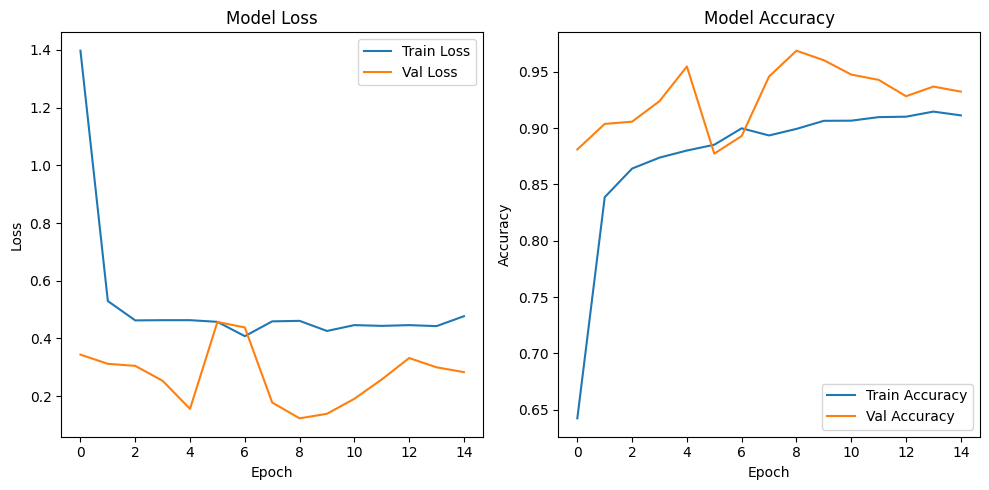

In [ ]:
loss=history.history['loss']
accuracy=history.history['accuracy']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_accuracy']

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Subplot 1 (Loss)
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Subplot 2 (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
val_images, val_labels = next(Val_generator)
predictions = model.predict(val_images)

2/2 [==============================] - 0s 25ms/step


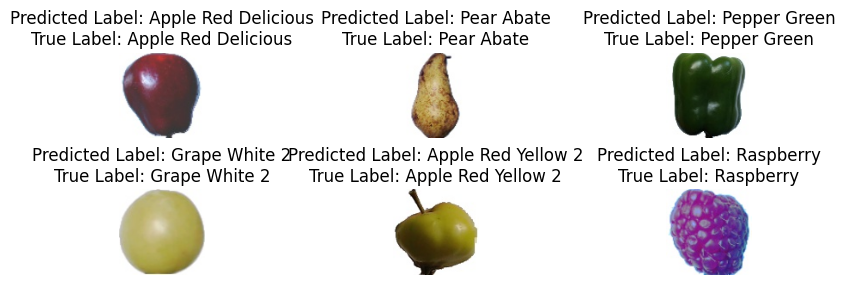

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.6)

for i in range(6):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(val_labels[i])
    true_label = labels[true_label_index]

    # Show image

    plt.subplot(6, 3, i+1)
    plt.imshow(val_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
plt.show()

<a id="1"></a>
<div style="text-align:center;display:inline-block;">
    <h2 style="font-weight: bold;
               background-color:#A1B341;
               border-bottom: 1px solid #102C57;
               border-radius:0px 15px;
               border-width: 3px 5px;
               font-family:cursive;
               font-size: 24px;
               padding:10px; 
               margin-bottom:10px; 
               color:#000080;"
        ><i> Test Data </i></h2>
</div> 

In [ ]:
test_images, test_labels = next(test_generator)
predictions_test = model.predict(test_images)

2/2 [==============================] - 0s 24ms/step


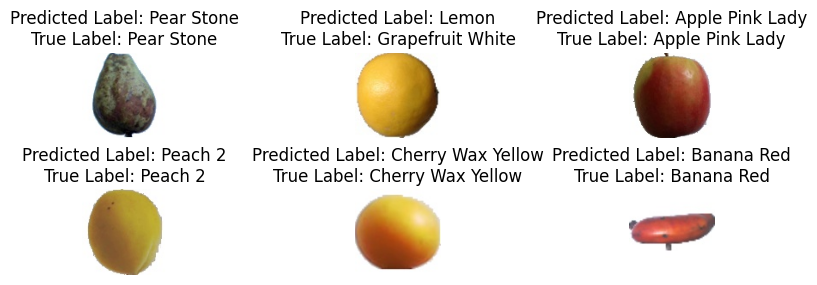

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.6)

for i in range(6):
    predicted_label_index = np.argmax(predictions_test[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    # Show image

    plt.subplot(6, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
plt.show()

## v) Let's Test Our Model

In [ ]:
labels = (train_img_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())

2/2 [==============================] - 0s 11ms/step


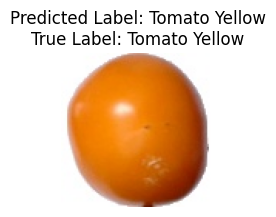

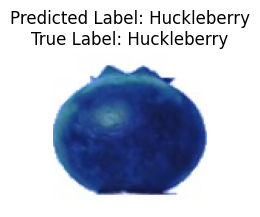

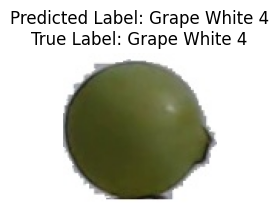

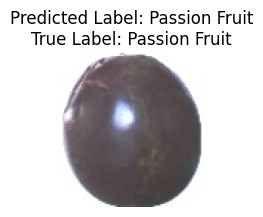

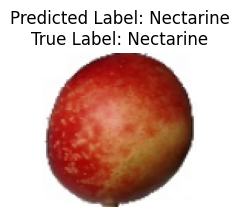

In [ ]:
test_images, test_labels = next(test_img_ds)
predictions = model.predict(test_images)

for i in range(5):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f'Predicted Label: {predicted_label}\nTrue Label: {true_label}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 26ms/step


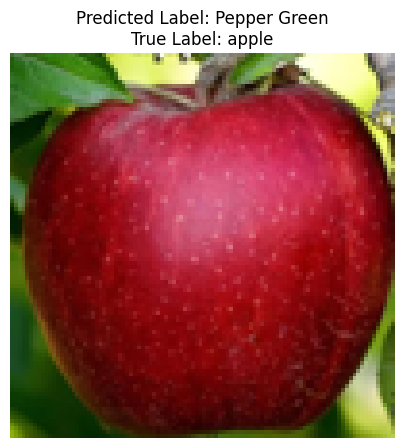

1/1 [==============================] - 0s 30ms/step


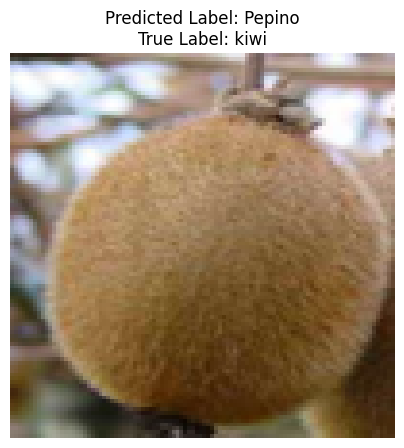

In [ ]:
image_paths = [
    "apple.JPG",
    "kiwi.JPG",
]

# Load images using PIL
images = []
for path in image_paths:
    try:
        img = Image.open(path)
        res = img.resize((100, 100))
        images.append(np.array(res) / 255.0)  # Normalize pixel values to range [0, 1]
    except FileNotFoundError:
        print(f"Error: Image file not found: {path}")

true_class = ['apple', 'kiwi']

# Predict labels using the model
if images:
    for i, img in enumerate(images):
        predictions_images_internet = model.predict(np.expand_dims(img, axis=0))  # Expand dimensions to match model input
        predicted_label_index = np.argmax(predictions_images_internet[0])  # Since predict returns a batch, take the first element
        predicted_label = labels[predicted_label_index]

        # Display the predicted labels along with the images
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_class[i]}")
        plt.axis('off')
        plt.show()

